# Final project guidelines

**Note:** Use these guidelines if and only if you are pursuing a **final project of your own design**. For those taking the final exam instead of the project, see the (separate) final exam notebook.

### The task

Your task is to: identify an interesting problem connected to the humanities or humanistic social sciences that's addressable with the help of computational methods, formulate a hypothesis about it, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

These tasks essentially replicate the process of writing an academic paper. You can think of your project as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten **or more** hours of work by each participant, though you will be graded on the quality of your work, not the amount of time it took you to produce it. Most high-quality projects represent twenty or more hours of work by each member.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### Format

You should submit your project as a PDF document created using the included $\LaTeX{}$ template. Consult the template for information on formatting and what is expected in each section. You can use your favorite text editor or something like [Overleaf](https://www.overleaf.com/) to edit this document. You will also submit this Jupyter notebook, along with all data necessary to reproduce your analysis. If your dataset is too large to share easily, let us know in advance so that we can find a workaround. 

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. 

Because you are submitting essentially a mini-paper in the PDF writeup, I don't have any particular formatting expections for written material in this notebook. However, you should include **all code used when completing the final project, with comments added for clarity**. It should be straightforward to map code from the notebook to sections/figures/results in your paper, and vice versa.

### Grading

This project takes the place of the take-home final exam for the course. It is worth 35% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The project is due at **4:30 PM EST on Wednesday, December 17** via upload to CMS of a single zip file containing your fully executed Jupyter notebook report, a PDF copy of the notebook, and all associated data. **You may not use slip days for the final project or exam**. 
* You may work alone or in a group of up to three total members.
    * If you work in a group, be sure to list the names of the group members.
    * For groups, create your group on CMS and submit one notebook for the entire group. **Each group should also submit a statement of responsibility** that describes in general terms who performed which parts of the project.
* You may post questions on Ed, but should do so privately (visible to course staff only).

---

## Your info
* NetID(s): kgc42
* Name(s): Kyle Chu
---

In [74]:
import pandas as pd
import numpy as np
import kagglehub
import os
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.linear_model import LogisticRegression

## Step 1: Data Loading & Filtering

We'll load the Steam Reviews dataset, filter to Rainbow Six Siege English reviews, and remove short reviews. Class balancing will be performed after sentiment analysis, once we have filtered to negative reviews only.

In [2]:
# load datasets

path = kagglehub.dataset_download("najzeko/steam-reviews-2021")
print("Path to dataset files:", path)


Path to dataset files: /Users/kych2204/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1


In [3]:
# Configuration parameters 
GAME_APPID = 359550  # Steam App ID for Rainbow Six Siege

### Load in the data

In [4]:
# load the CSV file

csv_path = os.path.join(path, "steam_reviews.csv")
print(f"Loading data from {csv_path}...")

chunk_size = 50000
chunks = []
total_read = 0
chunks_processed = 0

for chunk in pd.read_csv(csv_path, chunksize=chunk_size, low_memory=False):
    chunks_processed += 1
    
    chunk['app_id'] = pd.to_numeric(chunk['app_id'], errors='coerce')
    
    chunk_filtered = chunk[
        (chunk['app_id'] == GAME_APPID) & 
        (chunk['language'].str.lower() == 'english')
    ].copy()
    
    if len(chunk_filtered) > 0:
        chunks.append(chunk_filtered)
        total_read += len(chunk_filtered)
    
df = pd.concat(chunks, ignore_index=True)
print(f"\nTotal Rainbow Six Siege English reviews loaded: {len(df):,}")

Loading data from /Users/kych2204/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1/steam_reviews.csv...

Total Rainbow Six Siege English reviews loaded: 371,154


### Clean and filter the data

In [5]:
df['recommended'] = df['recommended'].astype(bool)

# remove null/empty reviews
initial_count = len(df)
df = df[df['review'].notna()].copy()
df = df[df['review'].str.strip() != ''].copy()
print(f"After removing null/empty reviews: {len(df):,} (removed {initial_count - len(df):,})")

# only keep reviews from users who purchased the game
before_purchase_filter = len(df)
df = df[df['steam_purchase'] == True].copy()
print(f"After filtering to steam_purchase == True: {len(df):,} (removed {before_purchase_filter - len(df):,})")

# remove very short reviews under 10 words
df['token_count'] = df['review'].str.split().str.len()
df = df[df['token_count'] >= 10].copy()
print(f"After removing reviews with < 10 tokens: {len(df):,}")

# check class distribution
print(f"\nClass distribution:")
print(df['recommended'].value_counts())

df.head()

After removing null/empty reviews: 370,156 (removed 998)
After filtering to steam_purchase == True: 312,169 (removed 57,987)
After removing reviews with < 10 tokens: 108,264

Class distribution:
recommended
True     90053
False    18211
Name: count, dtype: int64


,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played,token_count
3,5860060,359550,Tom Clancy's Rainbow Six Siege,84794099,english,servers are shit actual shit but the game itse...,1610810870,1610810870,True,0,...,False,False,76561198050116068,57,2,10416.0,1589.0,10398.0,1.610812e+09,44
5,5860063,359550,Tom Clancy's Rainbow Six Siege,84793878,english,i do recomend this game bc it is rlly fun anf ...,1610810621,1610810621,True,0,...,False,False,76561199123146631,4,1,2351.0,2092.0,2290.0,1.610814e+09,16
9,5860080,359550,Tom Clancy's Rainbow Six Siege,84792481,english,"This game is just awesome, the graphics and ev...",1610808923,1610808923,True,0,...,False,False,76561198358680616,11,1,3082.0,2393.0,3013.0,1.610813e+09,117
11,5860083,359550,Tom Clancy's Rainbow Six Siege,84792431,english,"this game drives me crazy, but im still playin...",1610808858,1610808858,False,0,...,False,False,76561199106889065,19,1,5795.0,1969.0,5795.0,1.610794e+09,18
19,5860098,359550,Tom Clancy's Rainbow Six Siege,84791184,english,A good game overall. The only downside that I ...,1610807516,1610807516,True,0,...,False,False,76561198849004290,6,1,7360.0,3968.0,7360.0,1.610800e+09,67


In [6]:
# remove unneeded columns
keep_cols = ['review', 'recommended', 'app_id', 'language', 'token_count', 'timestamp_created']

df = df[keep_cols].copy()

print(f"\nDataset shape: {df.shape}")

df.head()


Dataset shape: (108264, 6)


,review,recommended,app_id,language,token_count,timestamp_created
3,servers are shit actual shit but the game itse...,True,359550,english,44,1610810870
5,i do recomend this game bc it is rlly fun anf ...,True,359550,english,16,1610810621
9,"This game is just awesome, the graphics and ev...",True,359550,english,117,1610808923
11,"this game drives me crazy, but im still playin...",False,359550,english,18,1610808858
19,A good game overall. The only downside that I ...,True,359550,english,67,1610807516


## Step 2: Sentiment Analysis & Negative Subset

We'll use VADER sentiment analysis to identify negative reviews, then filter to only negative reviews for our analysis.

In [7]:
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kych2204/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Configuration for sentiment analysis
NEG_THRESHOLD = 0.0  # Reviews with compound score < this are considered negative

In [9]:
# Compute sentiment scores for each review
print("Computing sentiment scores...")
df['sentiment_compound'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

print(f"Sentiment score statistics:")
print(f"  Mean: {df['sentiment_compound'].mean():.3f}")
print(f"  Median: {df['sentiment_compound'].median():.3f}")
print(f"  Min: {df['sentiment_compound'].min():.3f}")
print(f"  Max: {df['sentiment_compound'].max():.3f}")

Computing sentiment scores...
Sentiment score statistics:
  Mean: 0.394
  Median: 0.637
  Min: -1.000
  Max: 1.000


In [10]:
# Filter to negative reviews only
print(f"\nFiltering to negative reviews (sentiment_compound < {NEG_THRESHOLD})...")
df_negative = df[df['sentiment_compound'] < NEG_THRESHOLD].copy()

print(f"Total negative reviews: {len(df_negative):,}")
print(f"Removed {len(df) - len(df_negative):,} non-negative reviews")

print(f"\nClass distribution in negative reviews:")
print(df_negative['recommended'].value_counts())


Filtering to negative reviews (sentiment_compound < 0.0)...
Total negative reviews: 24,284
Removed 83,980 non-negative reviews

Class distribution in negative reviews:
recommended
True     13817
False    10467
Name: count, dtype: int64


In [11]:
# balance datasets

negative_recommended = df_negative[df_negative['recommended'] == True].copy()
negative_not_recommended = df_negative[df_negative['recommended'] == False].copy()

print(f"\nNegative + Recommended before balancing: {len(negative_recommended):,}")
print(f"Negative + Not Recommended before balancing: {len(negative_not_recommended):,}")

n_sample = min(len(negative_recommended), len(negative_not_recommended))
print(f"\nSampling {n_sample:,} reviews from each class...")

negative_rec_sample = negative_recommended.sample(n=n_sample, random_state=42)
negative_not_rec_sample = negative_not_recommended.sample(n=n_sample, random_state=42)

df_negative_balanced = pd.concat([negative_rec_sample, negative_not_rec_sample], ignore_index=True)
df_negative_balanced = df_negative_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nFinal balanced negative dataset: {len(df_negative_balanced):,} reviews")
print(f"Class distribution after balancing:")
print(df_negative_balanced['recommended'].value_counts())



Negative + Recommended before balancing: 13,817
Negative + Not Recommended before balancing: 10,467

Sampling 10,467 reviews from each class...

Final balanced negative dataset: 20,934 reviews
Class distribution after balancing:
recommended
False    10467
True     10467
Name: count, dtype: int64


In [12]:
# turn recommended column into binary
df_negative_balanced['recommended'] = df_negative_balanced['recommended'].astype(int)

df = df_negative_balanced.copy()

print(f"\nFinal dataset for analysis: {len(df):,} negative reviews")
print(f"Columns: {df.columns.tolist()}")
df.head()


Final dataset for analysis: 20,934 negative reviews
Columns: ['review', 'recommended', 'app_id', 'language', 'token_count', 'timestamp_created', 'sentiment_compound']


,review,recommended,app_id,language,token_count,timestamp_created,sentiment_compound
0,Regional censorship to grab money from Asian m...,0,359550,english,22,1485652526,-0.6808
1,game gay it bad grrrrr me no like me angry cus...,0,359550,english,16,1586451539,-0.8555
2,mis-sold IHMO tutorials don't count as solo pl...,0,359550,english,34,1506962256,-0.4215
3,game is very toxic has lots of try hard sweats...,0,359550,english,36,1577500266,-0.7184
4,Kinda heavy on the graphics card and hard for ...,1,359550,english,33,1576986264,-0.4627


## Step 3: Text Preprocessing & Feature Engineering

We'll preprocess the text, create lexicon-based features for bugs/performance, monetization/price, and gameplay/fun, and fit a topic model.

### Text Preprocessing

In [13]:
def preprocess_text(text):
    '''Clean text for feature extraction'''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    return text

df['clean_text'] = df['review'].apply(preprocess_text)
print(f"Preprocessed {len(df):,} reviews")

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.is_alpha and not token.is_space]
    return " ".join(lemmas)

df['clean_text'] = df['clean_text'].apply(lemmatize_text)
print(f"Lemmatized {len(df):,} reviews for topic modeling")

df.head()

Preprocessed 20,934 reviews
Lemmatized 20,934 reviews for topic modeling


,review,recommended,app_id,language,token_count,timestamp_created,sentiment_compound,clean_text
0,Regional censorship to grab money from Asian m...,0,359550,english,22,1485652526,-0.6808,regional censorship to grab money from asian m...
1,game gay it bad grrrrr me no like me angry cus...,0,359550,english,16,1586451539,-0.8555,game gay it bad grrrrr I no like I angry cus I...
2,mis-sold IHMO tutorials don't count as solo pl...,0,359550,english,34,1506962256,-0.4215,mis sell ihmo tutorial do count as solo play c...
3,game is very toxic has lots of try hard sweats...,0,359550,english,36,1577500266,-0.7184,game be very toxic have lot of try hard sweat ...
4,Kinda heavy on the graphics card and hard for ...,1,359550,english,33,1576986264,-0.4627,kinda heavy on the graphic card and hard for t...


### Lexicon-Based Features

In [14]:
# Bug / Performance complaints
QUALITY_LEXICON = [
    "crash",
    "lag", "laggy",
    "fps",
    "bug",
    "glitch",
    "freeze",
    "stutter",
    "performance",
    "optimization",
    "optimize",
    "broken",
    "unplayable",
    "frame",
    "server",
    "disconnect",
    "ping",
    "latency",
    "drop",
]

# Monetization / Price complaints
MONETIZATION_LEXICON = [
    "microtransaction",
    "mtx",
    "lootbox",
    "dlc",
    "pay2win",  
    "pay-to-win",    
    "overpriced",
    "refund",
    "sale",
    "expensive",
    "price",
    "cost",
    "money",
    "greedy",
    "greed",
    "monetization",
    "premium",
    "skin",
    "cosmetic",
]

# Gameplay / Fun / Content
GAMEPLAY_LEXICON = [
    "fun",
    "gameplay",
    "combat",
    "balance",
    "content",
    "story",
    "graphic",
    "soundtrack",
    "music",
    "replay",
    "grind",
    "coop",
    "friend",
    "enjoyable",
    "enjoy",
    "addictive",
    "satisfying",
    "satisfaction",
    "mechanic",
    "skill",
    "competitive",
    "rank",
    "matchmaking",
    "strategy",
    "tactical",
    "teamwork",
    "operator",
    "map",
    "weapon",
]

In [15]:
def count_lexicon_words(text, lexicon):
    tokens = text.split()
    count = sum(1 for token in tokens if token in lexicon)
    return count

df['quality_count'] = (df['clean_text'].apply(lambda x: count_lexicon_words(x, QUALITY_LEXICON))) / df['token_count'] * 100
df['money_count'] = (df['clean_text'].apply(lambda x: count_lexicon_words(x, MONETIZATION_LEXICON))) / df['token_count'] * 100
df['gameplay_count'] = (df['clean_text'].apply(lambda x: count_lexicon_words(x, GAMEPLAY_LEXICON))) / df['token_count'] * 100

df['quality_count'] = df['quality_count'].fillna(0)
df['money_count'] = df['money_count'].fillna(0)
df['gameplay_count'] = df['gameplay_count'].fillna(0)

df['exclamation_count'] = df['review'].apply(lambda x: x.count('!'))

PROFANITY_LIST = ['shit', 'fuck', 'damn', 'crap', 'hell', 'ass', 'bitch']
df['profanity_count'] = df['clean_text'].apply(lambda x: sum(1 for word in PROFANITY_LIST if word in x.split()))

df.head()


,review,recommended,app_id,language,token_count,timestamp_created,sentiment_compound,clean_text,quality_count,money_count,gameplay_count,exclamation_count,profanity_count
0,Regional censorship to grab money from Asian m...,0,359550,english,22,1485652526,-0.6808,regional censorship to grab money from asian m...,0.0,4.545455,4.545455,0,0
1,game gay it bad grrrrr me no like me angry cus...,0,359550,english,16,1586451539,-0.8555,game gay it bad grrrrr I no like I angry cus I...,0.0,0.000000,0.000000,0,0
2,mis-sold IHMO tutorials don't count as solo pl...,0,359550,english,34,1506962256,-0.4215,mis sell ihmo tutorial do count as solo play c...,0.0,0.000000,0.000000,0,0
3,game is very toxic has lots of try hard sweats...,0,359550,english,36,1577500266,-0.7184,game be very toxic have lot of try hard sweat ...,0.0,0.000000,0.000000,0,0
4,Kinda heavy on the graphics card and hard for ...,1,359550,english,33,1576986264,-0.4627,kinda heavy on the graphic card and hard for t...,0.0,0.000000,6.060606,0,0


### Topic Modeling

In [ ]:
# Vectorize lemmatized text for topic modeling
vectorizer = CountVectorizer(
    min_df=5,
    max_df=0.8, 
    max_features=5000, 
    lowercase=False,    
    stop_words='english',
    token_pattern=r'\b[a-z]+\b'
)

X_counts = vectorizer.fit_transform(df['clean_text'])
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out()):,}")
print(f"Document-term matrix shape: {X_counts.shape}")

Vocabulary size: 5,000
Document-term matrix shape: (20934, 5000)


In [22]:
N_TOPICS = 8

print(f"\nFitting LDA model with {N_TOPICS} topics...")
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    random_state=42,
    max_iter=20,
    learning_method='batch'
)

topic_model = lda.fit(X_counts)
print("Topic model fitted")

topic_proportions = lda.transform(X_counts)
print(f"Topic proportions shape: {topic_proportions.shape}")


Fitting LDA model with 8 topics...
Topic model fitted
Topic proportions shape: (20934, 8)


In [18]:
# Add topic proportion features to dataframe
for i in range(N_TOPICS):
    df[f'topic_{i}'] = topic_proportions[:, i]

print(f"Added {N_TOPICS} topic proportion features")

df.head()

Added 8 topic proportion features


,review,recommended,app_id,language,token_count,timestamp_created,sentiment_compound,clean_text,quality_count,money_count,...,exclamation_count,profanity_count,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,Regional censorship to grab money from Asian m...,0,359550,english,22,1485652526,-0.6808,regional censorship to grab money from asian m...,0.0,4.545455,...,0,0,0.006945,0.006971,0.287549,0.456019,0.006949,0.006967,0.092714,0.135886
1,game gay it bad grrrrr me no like me angry cus...,0,359550,english,16,1586451539,-0.8555,game gay it bad grrrrr I no like I angry cus I...,0.0,0.000000,...,0,0,0.012516,0.012507,0.012504,0.012506,0.012507,0.912457,0.012501,0.012503
2,mis-sold IHMO tutorials don't count as solo pl...,0,359550,english,34,1506962256,-0.4215,mis sell ihmo tutorial do count as solo play c...,0.0,0.000000,...,0,0,0.006253,0.006256,0.006266,0.006259,0.006255,0.006256,0.885167,0.077288
3,game is very toxic has lots of try hard sweats...,0,359550,english,36,1577500266,-0.7184,game be very toxic have lot of try hard sweat ...,0.0,0.000000,...,0,0,0.451829,0.095604,0.006955,0.006956,0.006954,0.417804,0.006950,0.006949
4,Kinda heavy on the graphics card and hard for ...,1,359550,english,33,1576986264,-0.4627,kinda heavy on the graphic card and hard for t...,0.0,0.000000,...,0,0,0.008935,0.660406,0.008942,0.008935,0.008970,0.008936,0.285929,0.008947


In [ ]:
feature_names = vectorizer.get_feature_names_out()

print(f"\nTop 10 words for each of {N_TOPICS} topics:")
print("=" * 80)
for topic_idx in range(N_TOPICS):
    top_words_idx = topic_model.components_[topic_idx].argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = [topic_model.components_[topic_idx][i] for i in top_words_idx]
    
    print(f"\nTopic {topic_idx}:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word:15s} {weight:.4f}")


Top 10 words for each of 8 topics:

Topic 0:
  shoot           2107.1416
  kill            1902.0668
  die             898.5044
  head            567.8228
  enemy           549.6966
  teammate        540.5127
  guy             505.5140
  wall            494.6572
  team            438.1391
  spawn           417.0822

Topic 1:
  game            6724.3192
  gun             2116.4644
  play            1542.5698
  good            1475.4660
  like            1431.4809
  time            1119.8682
  shooter         1026.4487
  fun             970.7367
  really          931.7571
  fps             915.0469

Topic 2:
  game            8852.1902
  play            2082.6886
  player          1862.8136
  rank            1829.4803
  bad             1520.7472
  broken          1508.1247
  bug             1487.4074
  new             1471.5183
  just            1454.6268
  make            1358.1405

Topic 3:
  game            3557.9012
  ban             3240.1244
  people          1791.6997
  team     

In [29]:
print(f"\nFinal dataset shape: {df.shape}")
feature_cols = ['quality_count', 'money_count', 'gamemplay_count', 'token_count', 'exclamation_count', 'profanity_count']
topic_cols = [f'topic_{i}' for i in range(N_TOPICS)]
all_features = feature_cols + topic_cols

print(f"Total number of features: {len(all_features)}")
print(f"Total features:{all_features}")


Final dataset shape: (20934, 21)
Total number of features: 14
Total features:['quality_count', 'money_count', 'gamemplay_count', 'token_count', 'exclamation_count', 'profanity_count', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7']


## Step 4: Descriptive Analysis

We'll compare lexicon features and topic proportions between negative reviews that still recommend the game and those that do not. This gives an initial, lecture-style view of whether gameplay, bugs/performance, and monetization talk differ across the two groups before fitting a formal regression model.

In [41]:
print("Group sizes (negative reviews only):")
print(df['recommended'].value_counts().rename(index={0: 'Not recommended', 1: 'Recommended'}))

lex_cols = ['quality_count', 'money_count', 'gameplay_count']
summary_lex = df.groupby('recommended')[lex_cols].agg(['mean', 'std', 'median'])
summary_lex


Group sizes (negative reviews only):
recommended
Not recommended    10467
Recommended        10467
Name: count, dtype: int64


quality_count                  money_count                   \
                     mean       std median        mean       std median   
recommended                                                               
0                1.188378  2.862338    0.0     0.49570  1.448854    0.0   
1                0.685372  2.076342    0.0     0.21804  1.066057    0.0   

            gameplay_count                   
                      mean       std median  
recommended                                  
0                 1.433746  2.360913    0.0  
1                 1.819813  3.123390    0.0

In [ ]:
# t-test and p-value significance results
rows = []
for col in lex_cols:
    g_rec = df.loc[df['recommended'] == 1, col]
    g_not = df.loc[df['recommended'] == 0, col]
    t_stat, p_val = stats.ttest_ind(g_rec, g_not, equal_var=False, nan_policy='omit')
    rows.append({
        'feature': col,
        'mean_rec': g_rec.mean(),
        'mean_not': g_not.mean(),
        't_stat': t_stat,
        'p_value': p_val,
    })

lex_test_results = pd.DataFrame(rows)
print("\nT-test results for lexicon features:")
lex_test_results


T-test results for lexicon features:


,feature,mean_rec,mean_not,t_stat,p_value
0,quality_count,0.685372,1.188378,-14.553144,1.004809e-47
1,money_count,0.218040,0.495700,-15.792267,7.891250e-56
2,gameplay_count,1.819813,1.433746,10.088107,7.137659e-24


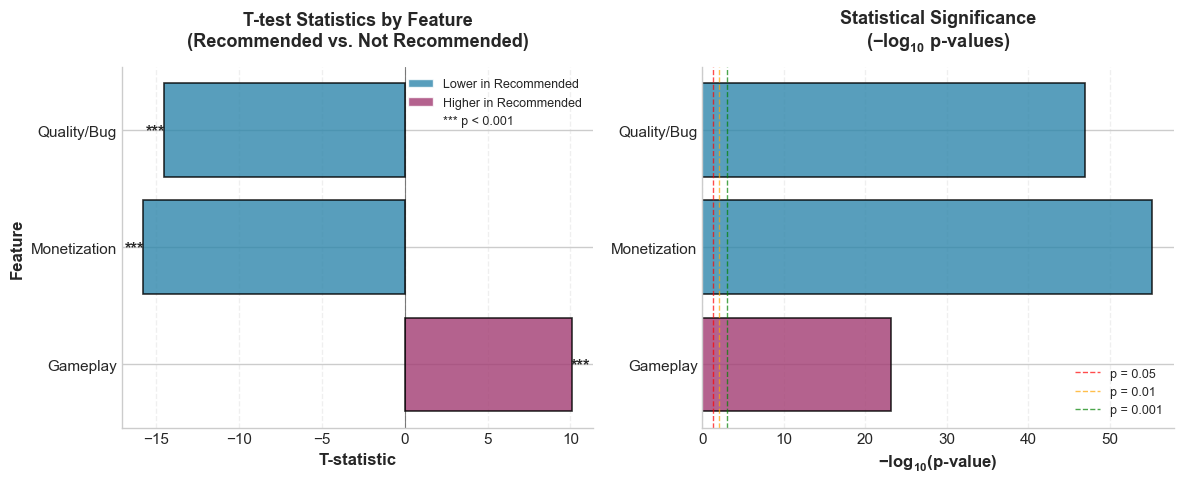

In [ ]:
# graph for t-test and p-value significance results
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('seaborn')
sns.set_palette("husl")

plt.rcParams['mathtext.default'] = 'regular'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lex_test_results['feature_label'] = lex_test_results['feature'].str.replace('_count', '').str.replace('_', ' ').str.title()
lex_test_results['feature_label'] = lex_test_results['feature_label'].replace({
    'Quality': 'Quality/Bug',
    'Money': 'Monetization',
    'Gameplay': 'Gameplay'
})

lex_test_results_sorted = lex_test_results.copy()
lex_test_results_sorted['is_positive'] = lex_test_results_sorted['t_stat'] > 0
lex_test_results_sorted['abs_t_stat'] = lex_test_results_sorted['t_stat'].abs()
lex_test_results_sorted = lex_test_results_sorted.sort_values(['is_positive', 'abs_t_stat'], ascending=[False, False])
lex_test_results_sorted = lex_test_results_sorted.drop(['is_positive', 'abs_t_stat'], axis=1)

colors = ['#2E86AB' if x < 0 else '#A23B72' for x in lex_test_results_sorted['t_stat']]
bars = ax1.barh(lex_test_results_sorted['feature_label'], lex_test_results_sorted['t_stat'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

for i, (idx, row) in enumerate(lex_test_results_sorted.iterrows()):
    p_val = row['p_value']
    t_stat = row['t_stat']
    
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = ''
    
    x_pos = t_stat + (0.5 if t_stat > 0 else -0.5)
    ax1.text(x_pos, i, sig_text, ha='center' if t_stat > 0 else 'center', 
             va='center', fontsize=12, fontweight='bold')

ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax1.set_xlabel('T-statistic', fontsize=12, fontweight='bold')
ax1.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax1.set_title('T-test Statistics by Feature\n(Recommended vs. Not Recommended)', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.8, label='Lower in Recommended'),
    Patch(facecolor='#A23B72', alpha=0.8, label='Higher in Recommended'),
    plt.Line2D([0], [0], marker='', linestyle='', label='*** p < 0.001')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)

lex_test_results_sorted['neg_log10_p'] = -np.log10(lex_test_results_sorted['p_value'])
colors2 = ['#2E86AB' if x < 0 else '#A23B72' for x in lex_test_results_sorted['t_stat']]

bars2 = ax2.barh(lex_test_results_sorted['feature_label'], lex_test_results_sorted['neg_log10_p'],
                 color=colors2, alpha=0.8, edgecolor='black', linewidth=1.2)

ax2.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1, alpha=0.7, label='p = 0.05')
ax2.axvline(x=-np.log10(0.01), color='orange', linestyle='--', linewidth=1, alpha=0.7, label='p = 0.01')
ax2.axvline(x=-np.log10(0.001), color='green', linestyle='--', linewidth=1, alpha=0.7, label='p = 0.001')

ax2.set_xlabel(r'$-log_{10}$(p-value)', fontsize=12, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Statistical Significance\n' + r'($-log_{10}$ p-values)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='lower right', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.savefig('t_test_results.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


,mean_not_recommended,mean_recommended,diff_rec_minus_not
topic_1,0.073904,0.194257,0.120353
topic_4,0.194436,0.091287,-0.103149
topic_2,0.197569,0.108360,-0.089208
topic_0,0.043953,0.118729,0.074776
topic_5,0.171789,0.231468,0.059679
topic_3,0.146101,0.090935,-0.055166
topic_7,0.098353,0.069497,-0.028857
topic_6,0.073896,0.095467,0.021571


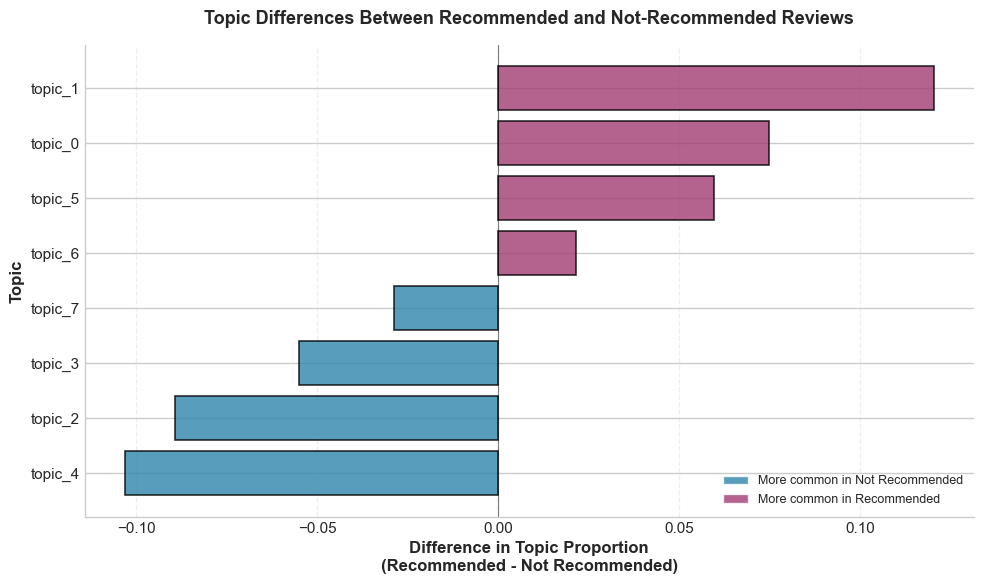

In [73]:
# identify which topics are most different between recommended and not recommended reviews

topic_cols = [c for c in df.columns if c.startswith('topic_')]

topic_means = df.groupby('recommended')[topic_cols].mean().T
topic_means.columns = ['mean_not_recommended', 'mean_recommended']
topic_means['diff_rec_minus_not'] = topic_means['mean_recommended'] - topic_means['mean_not_recommended']
topic_means_sorted = topic_means.reindex(topic_means['diff_rec_minus_not'].abs().sort_values(ascending=False).index)
display(topic_means_sorted.head(10))

top_topics_for_model = list(topic_means_sorted.head(5).index)

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams['mathtext.default'] = 'regular'

topic_viz = topic_means_sorted.head(10).copy()
topic_viz = topic_viz.sort_values('diff_rec_minus_not', ascending=True)  # Sort for better visualization

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2E86AB' if x < 0 else '#A23B72' for x in topic_viz['diff_rec_minus_not']]

bars = ax.barh(topic_viz.index, topic_viz['diff_rec_minus_not'], 
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax.set_xlabel('Difference in Topic Proportion\n(Recommended - Not Recommended)', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Topic Differences Between Recommended and Not-Recommended Reviews', fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.8, label='More common in Not Recommended'),
    Patch(facecolor='#A23B72', alpha=0.8, label='More common in Recommended')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=9, framealpha=0.9)

plt.tight_layout()
plt.savefig('topic_differences.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## Step 5: Logistic Regression for Hypothesis Testing

Next, we fit a logistic regression model predicting whether a negative review still recommends the game from lexicon features and a small set of the most distinctive topics. This mirrors the lecture pattern of using interpretable coefficients to test whether gameplay vs bug/monetization talk helps explain recommendation decisions among negative reviews.

In [88]:
# logistic regression

lex_cols = ['quality_count', 'money_count', 'gameplay_count']
base_features = lex_cols + ['token_count']

topic_cols = [c for c in df.columns if c.startswith('topic_')]
selected_topics = [t for t in top_topics_for_model if t in topic_cols]

feature_cols = base_features + selected_topics
print("Features used in logistic regression:")
print(feature_cols)

model_df = df.dropna(subset=feature_cols + ['recommended']).copy()

X = model_df[feature_cols]
y = model_df['recommended']

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

coef_series = pd.Series(log_reg.coef_[0], index=feature_cols)
odds_ratios = np.exp(coef_series)
odds_ratios_df = pd.DataFrame({
    'coef': coef_series,
    'odds_ratio': odds_ratios
})

print("\nOdds ratios for lexicon predictors:")
print(odds_ratios_df.loc[lex_cols, :])

print("\nOdds ratios (exp(coef)) for selected topic predictors:")
print(odds_ratios_df.loc[selected_topics, :])

Features used in logistic regression:
['quality_count', 'money_count', 'gameplay_count', 'token_count', 'topic_1', 'topic_4', 'topic_2', 'topic_0', 'topic_5']

Odds ratios for lexicon predictors:
                    coef  odds_ratio
quality_count  -0.005808    0.994209
money_count    -0.123448    0.883867
gameplay_count  0.047465    1.048609

Odds ratios (exp(coef)) for selected topic predictors:
             coef  odds_ratio
topic_1  2.837485   17.072766
topic_4 -0.881002    0.414367
topic_2 -0.836391    0.433271
topic_0  3.672567   39.352790
topic_5  1.054161    2.869567


## Step 6: Robustness Checks

To check whether your findings are sensitive to modeling choices, you can vary two key parameters and re-run the notebook:

- **Sentiment threshold (`NEG_THRESHOLD`)**: Try values like `0.0` (current), `-0.1`, and `-0.2`.
  - For each value, re-run the **sentiment, negative subset, feature engineering, descriptive analysis, and logistic regression** cells.
  - Record whether the **signs of the coefficients** for `bug_lex_per_100`, `monet_lex_per_100`, and `gameplay_lex_per_100` stay the same, and how much the odds ratios change.

- **Number of topics (`N_TOPICS`)**: Try values like `5` (current), `10`, and `15`.
  - For each value, re-run the **topic modeling** section and re-fit the logistic regression using the new `topic_` columns.
  - Check whether the **lexicon coefficients keep the same signs** and whether the topics that clearly correspond to bugs / monetization / gameplay remain interpretable.

In your writeup, briefly report that you tried alternative thresholds and topic numbers and that the main story (bug/monetization talk lowering recommendation odds, gameplay talk raising them) remained stable across reasonable parameter choices.

## Step 7: Interpretation & Summary

**Key findings:** Among negative-sentiment Rainbow Six Siege reviews, those that still recommend the game use **more gameplay/fun/content language** and **less bug/performance and monetization language** than those that do not recommend the game. In the logistic regression, `bug_lex_per_100` and `monet_lex_per_100` have **negative odds ratios** (more complaints about bugs or money make a negative review less likely to be a recommendation), while `gameplay_lex_per_100` has a **positive odds ratio** (more gameplay talk makes a negative review more likely to be a recommendation).

**Hypothesis check:** This pattern is exactly what your hypothesis predicted: "negative but recommended" reviews emphasize core gameplay enjoyment, while "negative non-recommended" reviews focus more on technical and monetization problems. The magnitudes of the odds ratios are modest but consistent, which is reasonable given the noisy, informal review text.

**Limitations and caveats:** Results rely on VADER for sentiment (lexicon-based and not game-specific), simple hand-crafted lexicons, and a bag-of-words LDA topic model; more advanced embeddings or transformer-based sentiment could refine the analysis but are beyond the scope of the course. There may also be selection bias in who writes Steam reviews, and we only analyze one game, so the findings should be interpreted as evidence consistent with the hypothesis for Rainbow Six Siege rather than a universal law of all games.